In [ ]:
# to get pygmsh do: sudo apt install python3-gmsh from https://anaconda.org/conda-forge/python-gmsh

/home/julian/anaconda3/lib/python3.7/site-packages/numpy/ctypeslib.py:523: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


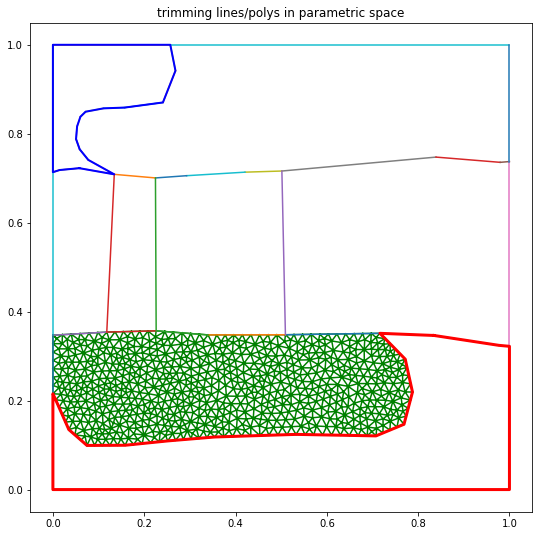

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

from wingflattenfuncs import P2, P3
from wingflattenfuncs import loadwingtrimlines, trimlinestopolygons
import pygmsh
import numpy

nodes, paths = loadwingtrimlines()
polys = trimlinestopolygons(nodes, paths)

plt.figure(figsize=(9,9))
for i in range(0, len(paths), 2):
    p0, p1 = nodes[paths[i]], nodes[paths[i+1]]
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]])
    
poly = polys[7]
X = [ nodes[p][0]  for p in poly ];  X.append(X[0])
Y = [ nodes[p][1]  for p in poly ];  Y.append(Y[0])
plt.plot(X, Y, linewidth=3, color="red")

poly = polys[5]
X = [ nodes[p][0]  for p in poly ];  X.append(X[0])
Y = [ nodes[p][1]  for p in poly ];  Y.append(Y[0])
plt.plot(X, Y, linewidth=2, color="blue")

poly = polys[1]
npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
with pygmsh.geo.Geometry() as g:
    g.add_polygon(npoly, mesh_size=0.02)
    mesh = g.generate_mesh()
X = mesh.points[:,0]
Y = mesh.points[:,1]
plt.triplot(X, Y, mesh.cells_dict["triangle"], color="green")

plt.title("trimming lines/polys in parametric space");

/home/julian/anaconda3/lib/python3.7/site-packages/numpy/ctypeslib.py:523: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


Text(0.5, 0.92, 'Triang')

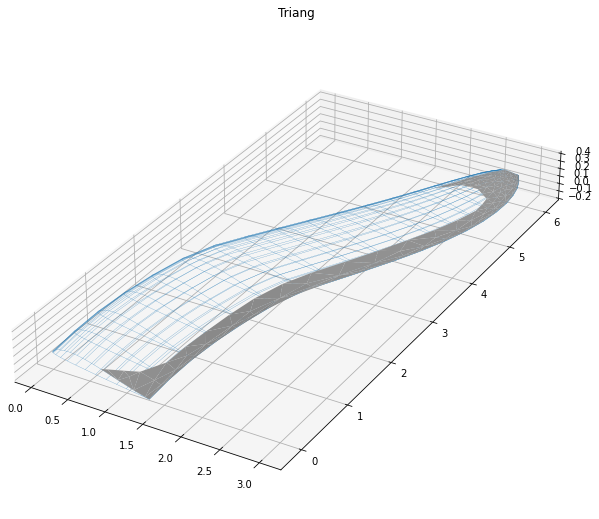

In [2]:
from wingflattenfuncs import loadwinggeometry
from wingflattenfuncs import wingwireframe, winguv2xyz

sections, zvals = loadwinggeometry()
wX, wY, wZ = wingwireframe(sections, zvals)

poly = polys[7]
npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
with pygmsh.geo.Geometry() as g:
    g.add_polygon(npoly, mesh_size=0.06)
    mesh = g.generate_mesh()

pts = [ winguv2xyz(p[0], p[1], sections, zvals)  for p in mesh.points ]
tX = [ p[0]  for p in pts ]
tY = [ p[1]  for p in pts ]
tZ = [ p[2]  for p in pts ]

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,2,0.2], zoom=1.3)
ax.plot_wireframe(wX, wZ, wY, linewidth=0.2)
ax.plot_trisurf(tX, tZ, Z=tY, triangles=mesh.cells_dict["triangle"], color="white")
plt.title("Triang")

In [3]:
import numpy
from wingflattenfuncs import trimeshesflattener, fullflattriareas, triprojpolyflattener

surfacemeshes = triprojpolyflattener(nodes, polys, sections, zvals, 0.02)



[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
mesh (pts=734, tris=1372) flattened
mesh (pts=752, tris=1397) flattened
mesh (pts=405, tris=740) flattened
mesh (pts=150, tris=251) flattened
mesh (pts=193, tris=332) flattened
mesh (pts=218, tris=368) flattened
mesh (pts=964, tris=1796) flattened
mesh (pts=705, tris=1253) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



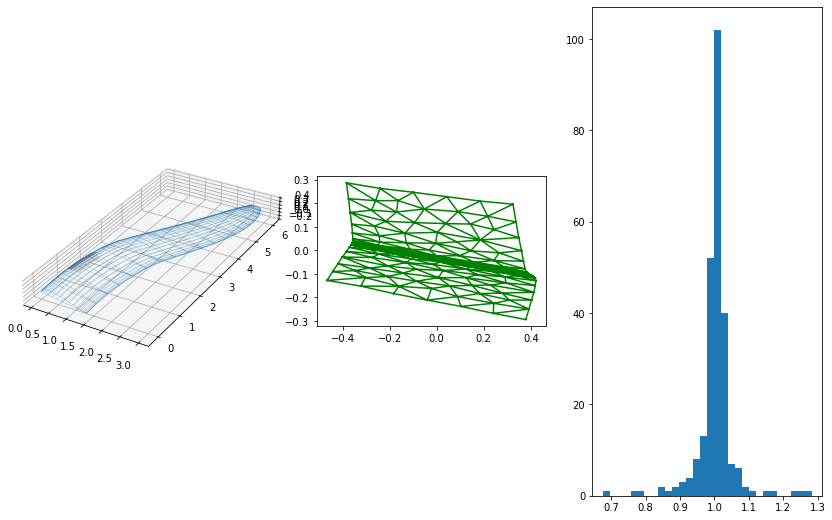

In [6]:
fig = plt.figure(figsize=(14,9))

surfacemesh = surfacemeshes[3]

pts = surfacemesh["pts"]
fpts = surfacemesh["fpts"]
tris = surfacemesh["tris"]
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_box_aspect([1,2,0.2], zoom=1.3)
ax.plot_wireframe(wX, wZ, wY, linewidth=0.2)
ax.plot_trisurf(pts[:,0], pts[:,2], Z=pts[:,1], triangles=tris, color="white")

fax = fig.add_subplot(1, 3, 2)
X = fpts[:,0]
Y = fpts[:,1]

fax.triplot(X, Y, tris, color="green")
fax.set_aspect("equal")

ax = fig.add_subplot(1, 3, 3)
triareas = fullflattriareas(surfacemesh)
ax.hist(triareas[:,1]/triareas[:,0], bins=30);

In [ ]:

def fullflattriareas(surfacemesh):
    ptsP = [ P3(*p)  for p in surfacemesh["pts"] ]
    fptsP = [ P2(*p)  for p in surfacemesh["fpts"] ]
    tris = surfacemesh["tris"]

    def P2Cross(a, b):
        return a.u*b.v - b.u*a.v

    triareas = [ ]
    for tri in tris:
        p0, p1, p2 = ptsP[tri[0]], ptsP[tri[1]], ptsP[tri[2]]
        parea = 0.5*P3.Cross(p1 - p0, p2 - p0).Len()
        f0, f1, f2 = fptsP[tri[0]], fptsP[tri[1]], fptsP[tri[2]]
        farea = 0.5*abs(P2Cross(f1 - f0, f2 - f0))
        #areachange = farea/parea
        triareas.append([parea, farea])
    return numpy.array(triareas)


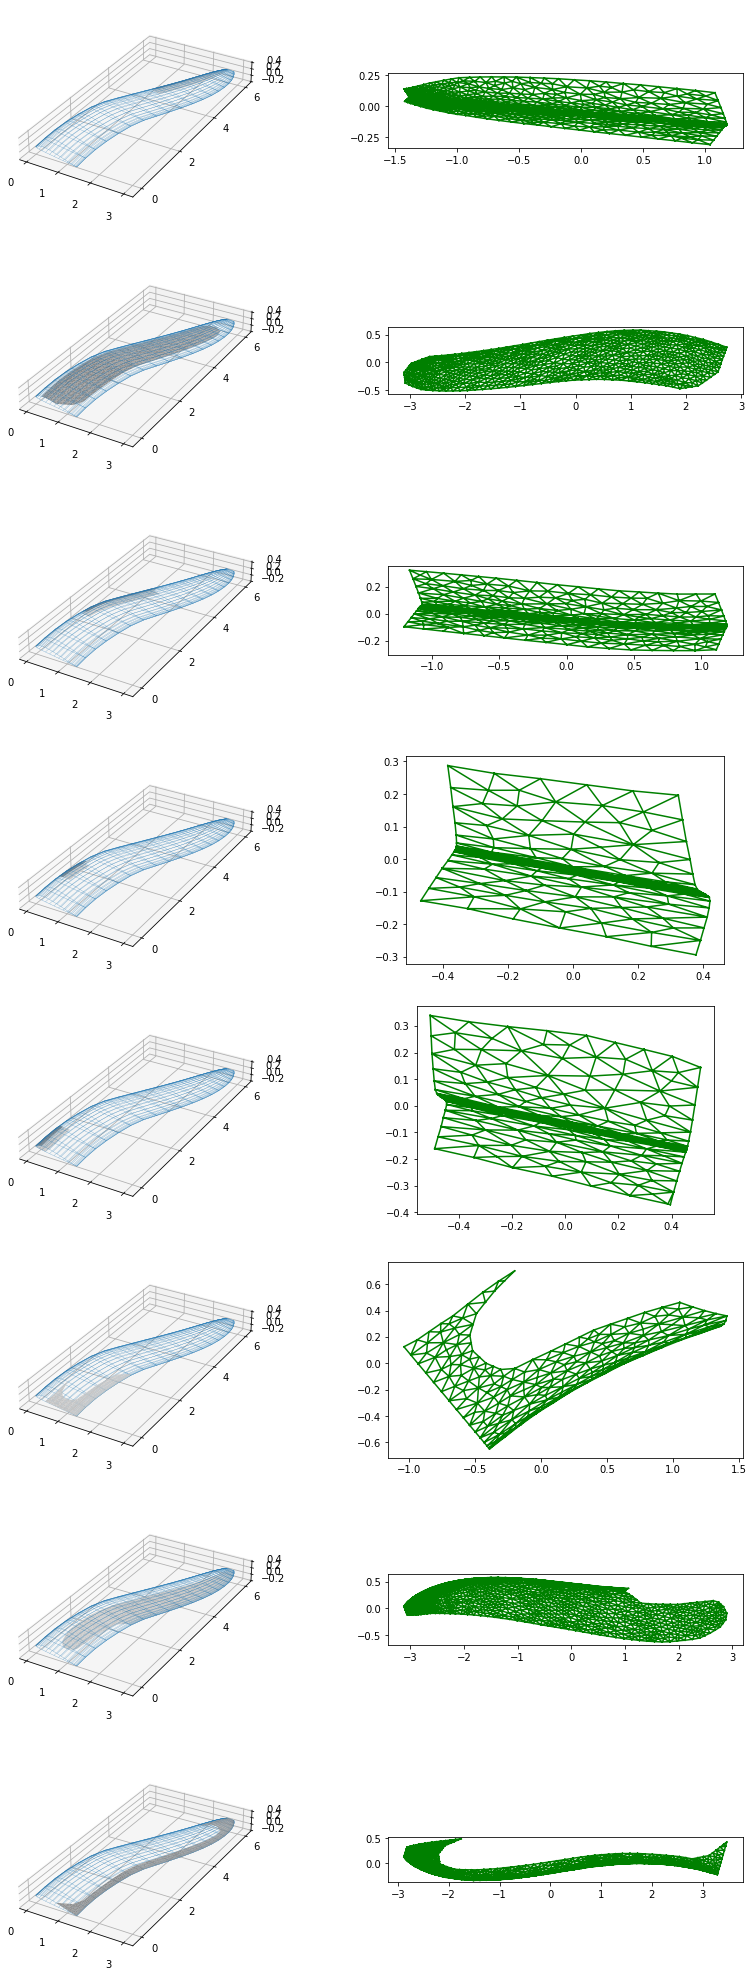

In [35]:
fig = plt.figure(figsize=(14,36))

nrows = len(surfacemeshes)
for i in range(nrows):
    surfacemesh = surfacemeshes[i]
    pts = surfacemesh["pts"]
    fpts = surfacemesh["fpts"]
    tris = surfacemesh["tris"]
    ax = fig.add_subplot(nrows, 2, i*2+1, projection='3d')
    ax.set_box_aspect([1,2,0.2], zoom=1.3)
    ax.plot_wireframe(wX, wZ, wY, linewidth=0.2)
    ax.plot_trisurf(pts[:,0], pts[:,2], Z=pts[:,1], triangles=tris, color="white")

    fax = fig.add_subplot(nrows, 2, i*2+2)
    X = fpts[:,0]
    Y = fpts[:,1]

    fax.triplot(X, Y, tris, color="green")
    fax.set_aspect("equal")
    triareas = fullflattriareas(surfacemesh)

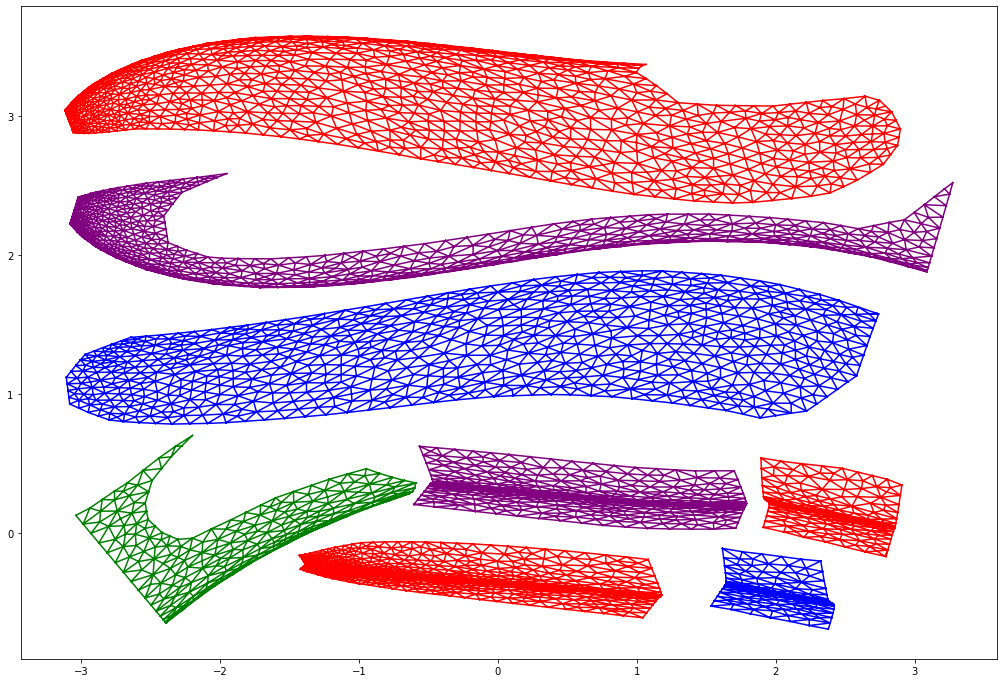

In [77]:
fig = plt.figure(figsize=(18,12))
coffsets = [(5, -2, 0, "green"), (1, 0, 1.3, "blue"), 
            (0, 0, -0.3, "red"), (2, 0.6, +0.3, "purple"),
            (3, 2, -0.4, "blue"), (4, 2.4, 0.2, "red"), 
            (6, 0, 3, "red"), (7, -0.2, 2.1, "purple")]
fax = fig.add_subplot()
for i, tx, ty, col in coffsets:
    surfacemesh = surfacemeshes[i]
    pts = surfacemesh["pts"]
    fpts = surfacemesh["fpts"]
    tris = surfacemesh["tris"]
    X = fpts[:,0]+tx
    Y = fpts[:,1]+ty
    fax.triplot(X, Y, tris, color=col)
    fax.set_aspect("equal")

In [36]:
import ipyvolume as ipv
ipv.figure()

for i,col in [(7,"red"), (1,"blue"), (0,"green")]:
    poly = polys[i]
    npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
    with pygmsh.geo.Geometry() as g:
        g.add_polygon(npoly, mesh_size=0.06)
        mesh = g.generate_mesh()

    pts = [ winguv2xyz(p[0], p[1], sections, zvals)  for p in mesh.points ]
    tX = [ p[0]  for p in pts ]
    tY = [ p[1]  for p in pts ]
    tZ = [ p[2]  for p in pts ]

    tris = mesh.cells_dict["triangle"]
    lines = list(tris[:,:2])+list(tris[:,1:])
    ipv.plot_trisurf(tX, tZ, tY, lines=lines, color=col)
    
ipv.show()

/home/julian/anaconda3/lib/python3.7/site-packages/numpy/ctypeslib.py:523: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)
